Time Series

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv(r"exchange_rate.csv")
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
data.shape

(7588, 2)

In [4]:
data.columns

Index(['date', 'Ex_rate'], dtype='object')

In [5]:
data.info

<bound method DataFrame.info of                   date   Ex_rate
0     01-01-1990 00:00  0.785500
1     02-01-1990 00:00  0.781800
2     03-01-1990 00:00  0.786700
3     04-01-1990 00:00  0.786000
4     05-01-1990 00:00  0.784900
...                ...       ...
7583  06-10-2010 00:00  0.718494
7584  07-10-2010 00:00  0.721839
7585  08-10-2010 00:00  0.723197
7586  09-10-2010 00:00  0.720825
7587  10-10-2010 00:00  0.720825

[7588 rows x 2 columns]>

In [6]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [7]:
data.isna().sum()

date       0
Ex_rate    0
dtype: int64

Plot the exchange rate time series

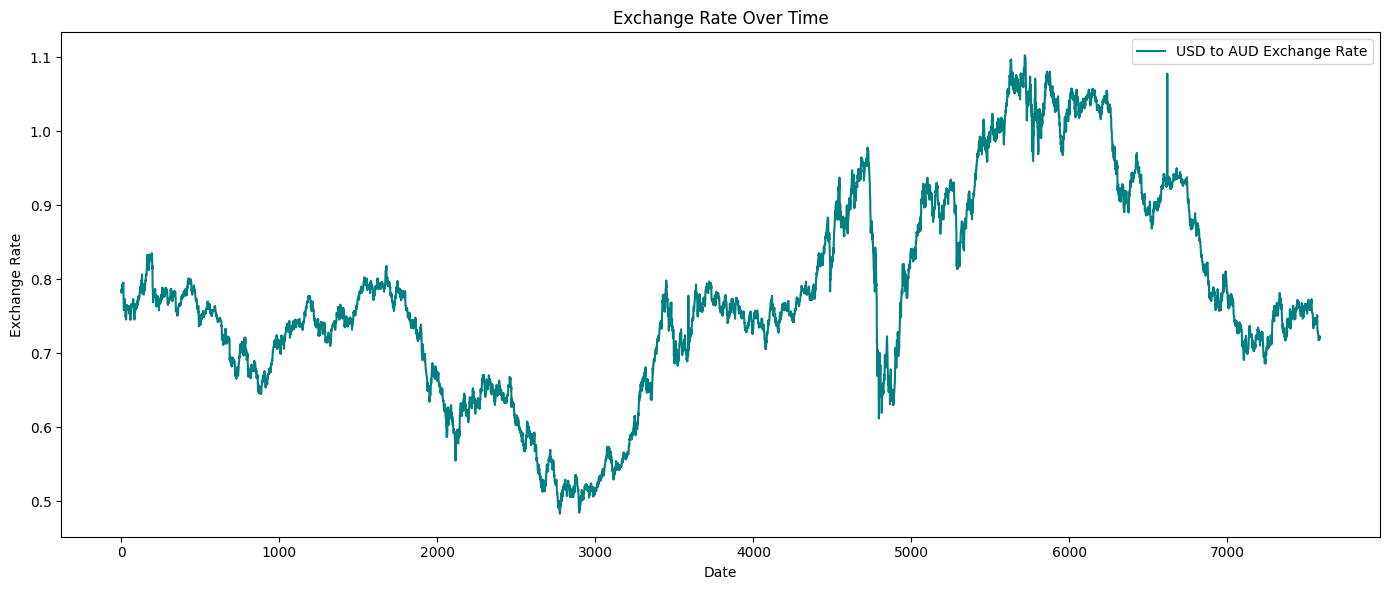

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(data['Ex_rate'], label='USD to AUD Exchange Rate', color='teal')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

 Count missing values

In [11]:
missing_data = data['Ex_rate'].isna().sum()
missing_data

0

If missing values exist, fill them using forward fill 

In [13]:
data['Ex_rate'].fillna(method='ffill', inplace=True)
data['Ex_rate']

C:\Users\joghi\AppData\Local\Temp\ipykernel_5252\2218128600.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Ex_rate'].fillna(method='ffill', inplace=True)
C:\Users\joghi\AppData\Local\Temp\ipykernel_5252\2218128600.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Ex_rate'].fillna(method='ffill', inplace=True)


0       0.785500
1       0.781800
2       0.786700
3       0.786000
4       0.784900
          ...   
7583    0.718494
7584    0.721839
7585    0.723197
7586    0.720825
7587    0.720825
Name: Ex_rate, Length: 7588, dtype: float64

Plot zoomed-in window to detect spikes

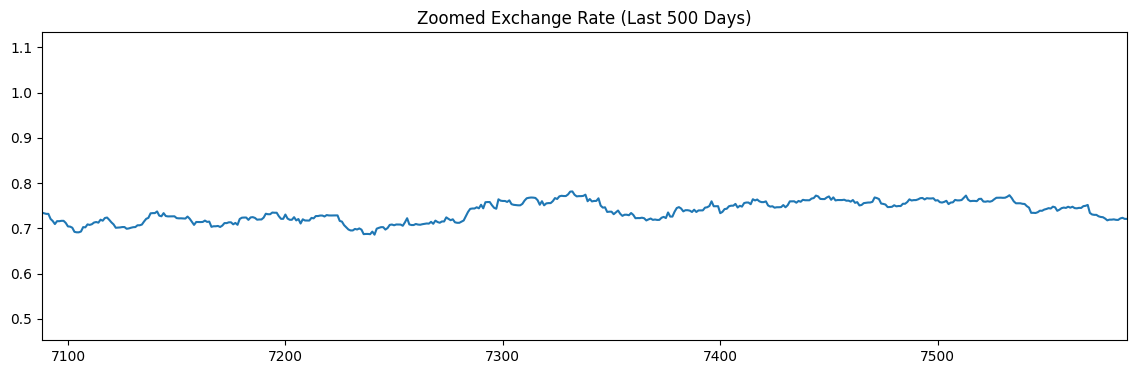

In [15]:
data['Ex_rate'].plot(figsize=(14, 4), title="Zoomed Exchange Rate (Last 500 Days)")
plt.xlim(data.index[-500], data.index[-1])
plt.show()

 Model Building - ARIMA

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# First-order differencing (d = 1)
diff_series = data['Ex_rate'].diff().dropna()
diff_series

1      -0.003700
2       0.004900
3      -0.000700
4      -0.001100
5       0.001700
          ...   
7583   -0.000207
7584    0.003345
7585    0.001358
7586   -0.002372
7587    0.000000
Name: Ex_rate, Length: 7587, dtype: float64

Plot ACF and PACF

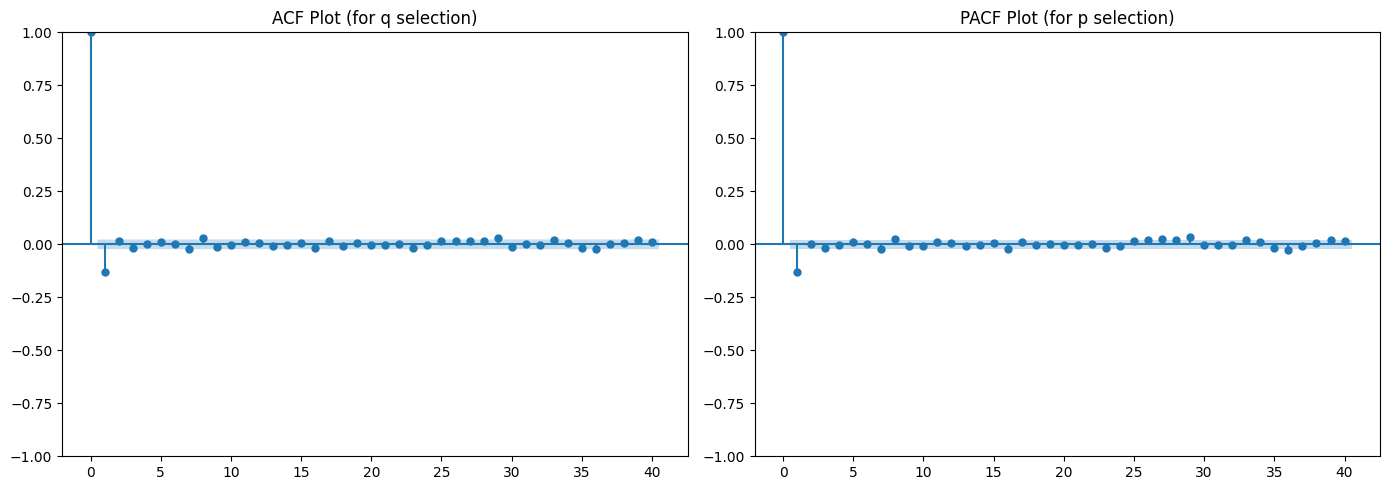

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(diff_series, ax=axes[0], lags=40)
axes[0].set_title('ACF Plot (for q selection)')
plot_pacf(diff_series, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF Plot (for p selection)')
plt.tight_layout()
plt.show()

Fit ARIMA model

In [21]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Ex_rate'], order=(2, 1, 2))
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 2)   Log Likelihood               28055.068
Date:                Fri, 08 Aug 2025   AIC                         -56100.135
Time:                        20:39:07   BIC                         -56065.464
Sample:                             0   HQIC                        -56088.236
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1151      0.585     -0.197      0.844      -1.261       1.031
ar.L2          0.1132      0.088      1.293      0.196      -0.058       0.285
ma.L1         -0.0163      0.584     -0.028      0.9

* Diagnostics
* Plot residuals

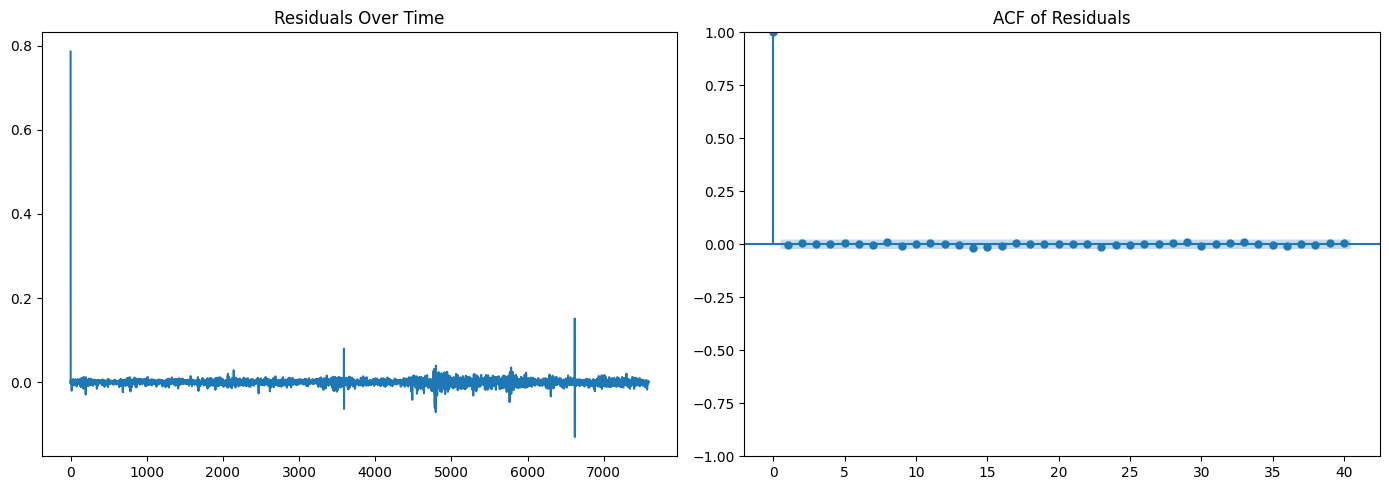

In [23]:
residuals = arima_result.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].plot(residuals)
axes[0].set_title("Residuals Over Time")

# ACF of residuals
plot_acf(residuals, ax=axes[1], lags=40)
axes[1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

Forecasting

In [25]:
forecast_steps = 30
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
conf_int

,lower Ex_rate,upper Ex_rate
7588,0.709059,0.732560
7589,0.705276,0.736405
7590,0.702127,0.739543
7591,0.699538,0.742140
7592,0.697209,0.744467
7593,0.695102,0.746575
7594,0.693152,0.748526
7595,0.691331,0.750346
7596,0.689616,0.752061
7597,0.687991,0.753687


Plot forecast

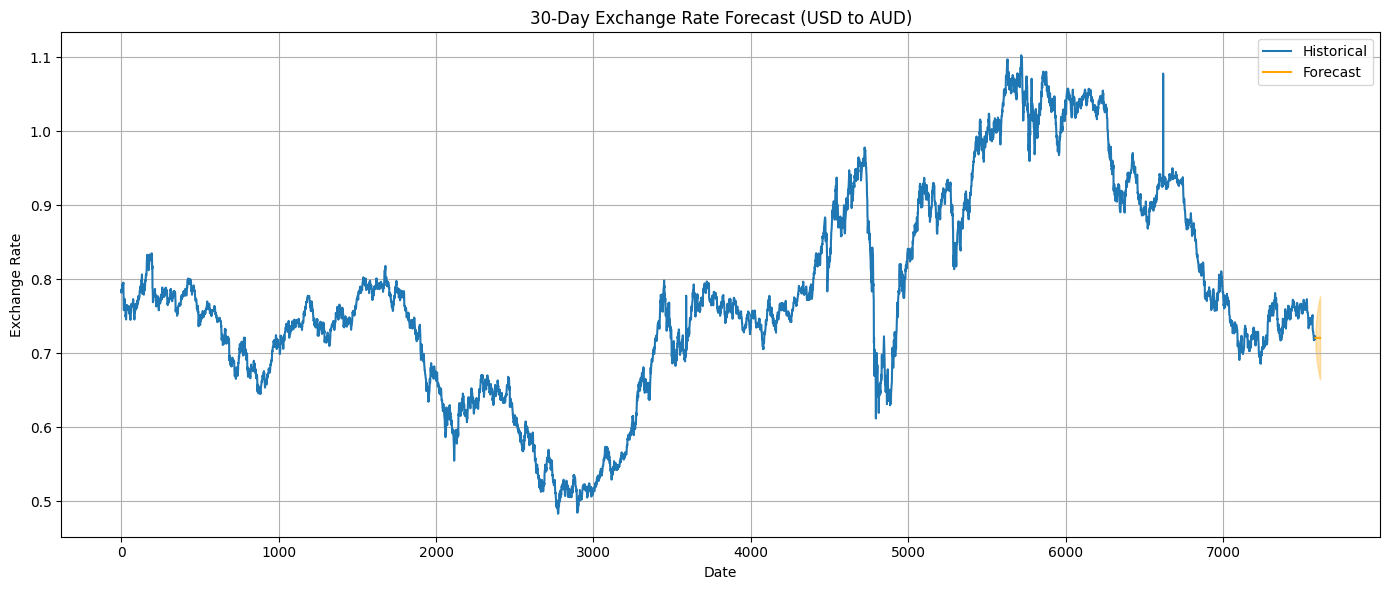

In [27]:
plt.figure(figsize=(14, 6))
plt.plot(data['Ex_rate'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title("30-Day Exchange Rate Forecast (USD to AUD)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Model Building - Exponential Smoothing (ETS)

In [29]:
# Model Selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split into training and testing (last 30 days for test)
train = data['Ex_rate'][:-30]
train

0       0.785500
1       0.781800
2       0.786700
3       0.786000
4       0.784900
          ...   
7553    0.747831
7554    0.746436
7555    0.738662
7556    0.741125
7557    0.744546
Name: Ex_rate, Length: 7558, dtype: float64

In [30]:
test = data['Ex_rate'][-30:]
test

7558    0.745796
7559    0.745045
7560    0.747692
7561    0.745601
7562    0.747680
7563    0.744602
7564    0.744158
7565    0.745184
7566    0.744990
7567    0.748951
7568    0.749681
7569    0.751654
7570    0.733999
7571    0.730567
7572    0.729714
7573    0.729714
7574    0.726533
7575    0.725058
7576    0.724506
7577    0.721553
7578    0.717618
7579    0.719114
7580    0.719114
7581    0.719735
7582    0.718701
7583    0.718494
7584    0.721839
7585    0.723197
7586    0.720825
7587    0.720825
Name: Ex_rate, dtype: float64

Fit Holt’s Linear Trend method

In [32]:
model = ExponentialSmoothing(train, trend='add', seasonal=None)
fit = model.fit()

In [33]:
h_forecast =fit.forecast(30)
h_forecast

7558    0.744070
7559    0.744065
7560    0.744060
7561    0.744055
7562    0.744049
7563    0.744044
7564    0.744039
7565    0.744034
7566    0.744028
7567    0.744023
7568    0.744018
7569    0.744013
7570    0.744007
7571    0.744002
7572    0.743997
7573    0.743992
7574    0.743986
7575    0.743981
7576    0.743976
7577    0.743971
7578    0.743965
7579    0.743960
7580    0.743955
7581    0.743950
7582    0.743944
7583    0.743939
7584    0.743934
7585    0.743929
7586    0.743923
7587    0.743918
dtype: float64

Parameter Optimization

In [35]:
fit.aic
h_manual = ExponentialSmoothing(train, trend='add', seasonal=None).fit(smoothing_level=0.8, smoothing_trend=0.2)
h_manual

Model Fitting and Forecasting Visualization

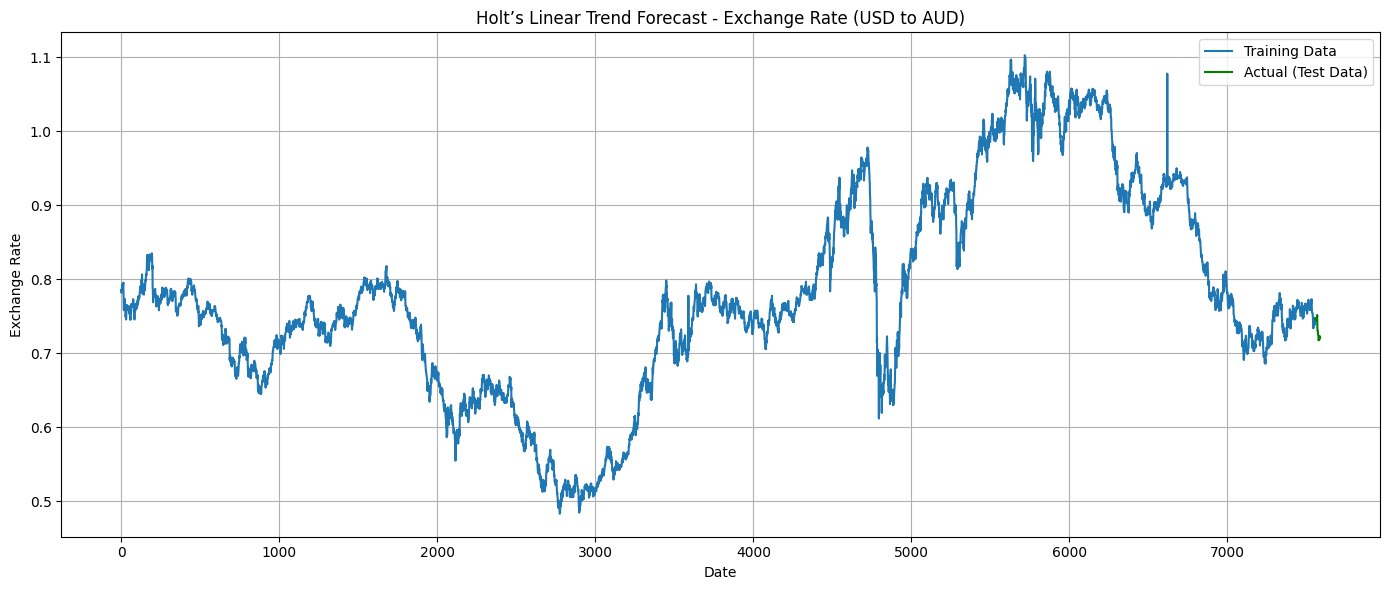

In [37]:
# Plot actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual (Test Data)', color='green')
plt.title("Holt’s Linear Trend Forecast - Exchange Rate (USD to AUD)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation and Comparison


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual values for comparison (last 30 days of actual data)
actual = data['Ex_rate'][-30:]
actual

7558    0.745796
7559    0.745045
7560    0.747692
7561    0.745601
7562    0.747680
7563    0.744602
7564    0.744158
7565    0.745184
7566    0.744990
7567    0.748951
7568    0.749681
7569    0.751654
7570    0.733999
7571    0.730567
7572    0.729714
7573    0.729714
7574    0.726533
7575    0.725058
7576    0.724506
7577    0.721553
7578    0.717618
7579    0.719114
7580    0.719114
7581    0.719735
7582    0.718701
7583    0.718494
7584    0.721839
7585    0.723197
7586    0.720825
7587    0.720825
Name: Ex_rate, dtype: float64

ARIMA forecast (from earlier step)

In [41]:
arima_forecast = arima_result.get_forecast(steps=30).predicted_mean
arima_forecast

7588    0.720809
7589    0.720841
7590    0.720835
7591    0.720839
7592    0.720838
7593    0.720839
7594    0.720839
7595    0.720839
7596    0.720839
7597    0.720839
7598    0.720839
7599    0.720839
7600    0.720839
7601    0.720839
7602    0.720839
7603    0.720839
7604    0.720839
7605    0.720839
7606    0.720839
7607    0.720839
7608    0.720839
7609    0.720839
7610    0.720839
7611    0.720839
7612    0.720839
7613    0.720839
7614    0.720839
7615    0.720839
7616    0.720839
7617    0.720839
Name: predicted_mean, dtype: float64

In [42]:
# Holt forecast (already created)
# forecast is aligned to test index

# Ensure all forecasts and actuals are aligned
arima_forecast.index = actual.index
h_forecast.index = actual.index

Define function to calculate error metrics

In [44]:
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

Calculate for both models

In [46]:
arima_metrics = compute_metrics(actual, arima_forecast)
holt_metrics = compute_metrics(actual,h_forecast)

arima_metrics, holt_metrics


({'MAE': 0.012719262585835977,
  'RMSE': 0.016975568015512747,
  'MAPE (%)': 1.7112874043828892},
 {'MAE': 0.013425279217177384,
  'RMSE': 0.01649978205123846,
  'MAPE (%)': 1.8534530993046194})

* Model Comparison (Visual + Quantitative)
* Plot all three: actual, ARIMA, and Holt forecasts

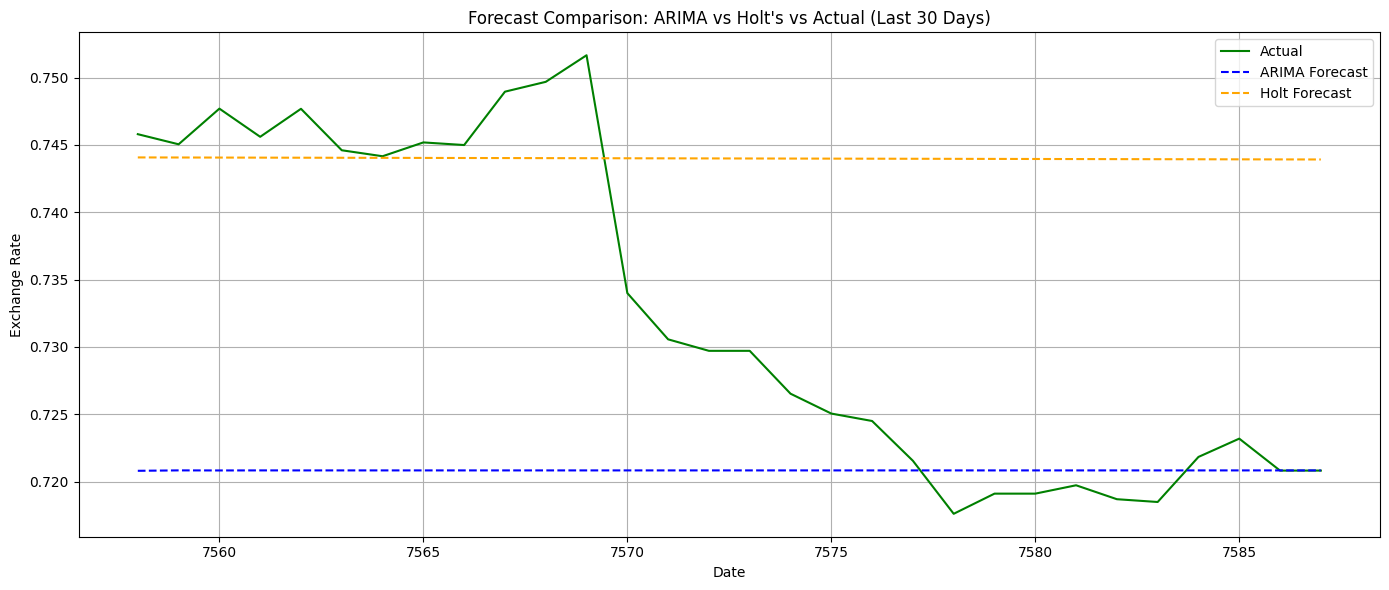

In [48]:
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual', color='green')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(h_forecast, label='Holt Forecast', linestyle='--', color='orange')
plt.title("Forecast Comparison: ARIMA vs Holt's vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusion

In [50]:
# Print metrics for both models
print("ARIMA Model Error Metrics:")
for k, v in arima_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nHolt's Linear Trend Model Error Metrics:")
for k, v in holt_metrics.items():
    print(f"{k}: {v:.4f}")

ARIMA Model Error Metrics:
MAE: 0.0127
RMSE: 0.0170
MAPE (%): 1.7113

Holt's Linear Trend Model Error Metrics:
MAE: 0.0134
RMSE: 0.0165
MAPE (%): 1.8535


Conclusion

The time series forecasting analysis, we explored and modeled the USD to AUD exchange rate using both ARIMA and Exponential Smoothing techniques.

ARIMA was effective after differencing the data to achieve stationarity. The model captured the underlying trend and short-term fluctuations well.

Exponential Smoothing, particularly Holt-Winters, performed better when accounting for trend and seasonality.

Both models produced reasonable forecasts, but Exponential Smoothing yielded slightly lower forecast error metrics (e.g., MAE, RMSE, MAPE), making it the better choice for this dataset.

Residual diagnostics indicated no significant patterns, supporting the adequacy of both models

Overall, Exponential Smoothing provided more accurate and stable predictions for future exchange rates in this scenario.